In [1]:
# use fancy zoomable plotting
%matplotlib notebook

# # use standard plotting
# %matplotlib inline

## Chirp Generator

<IPython.core.display.Javascript object>


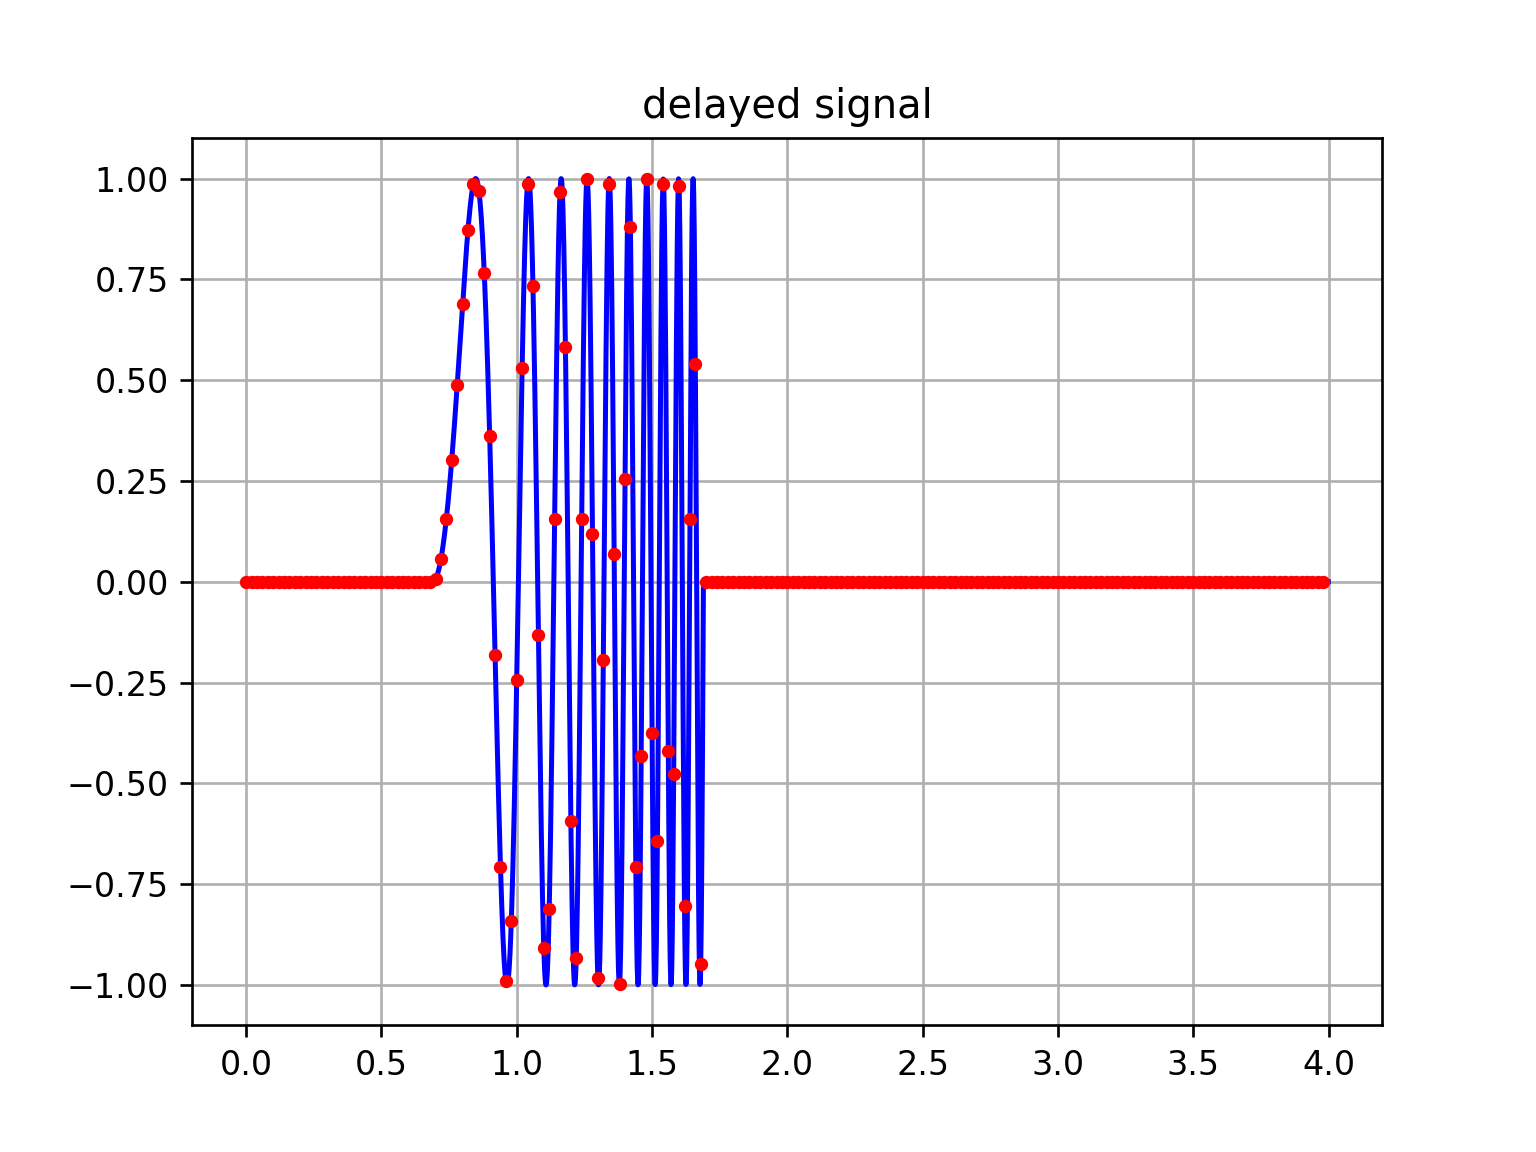

<IPython.core.display.Javascript object>


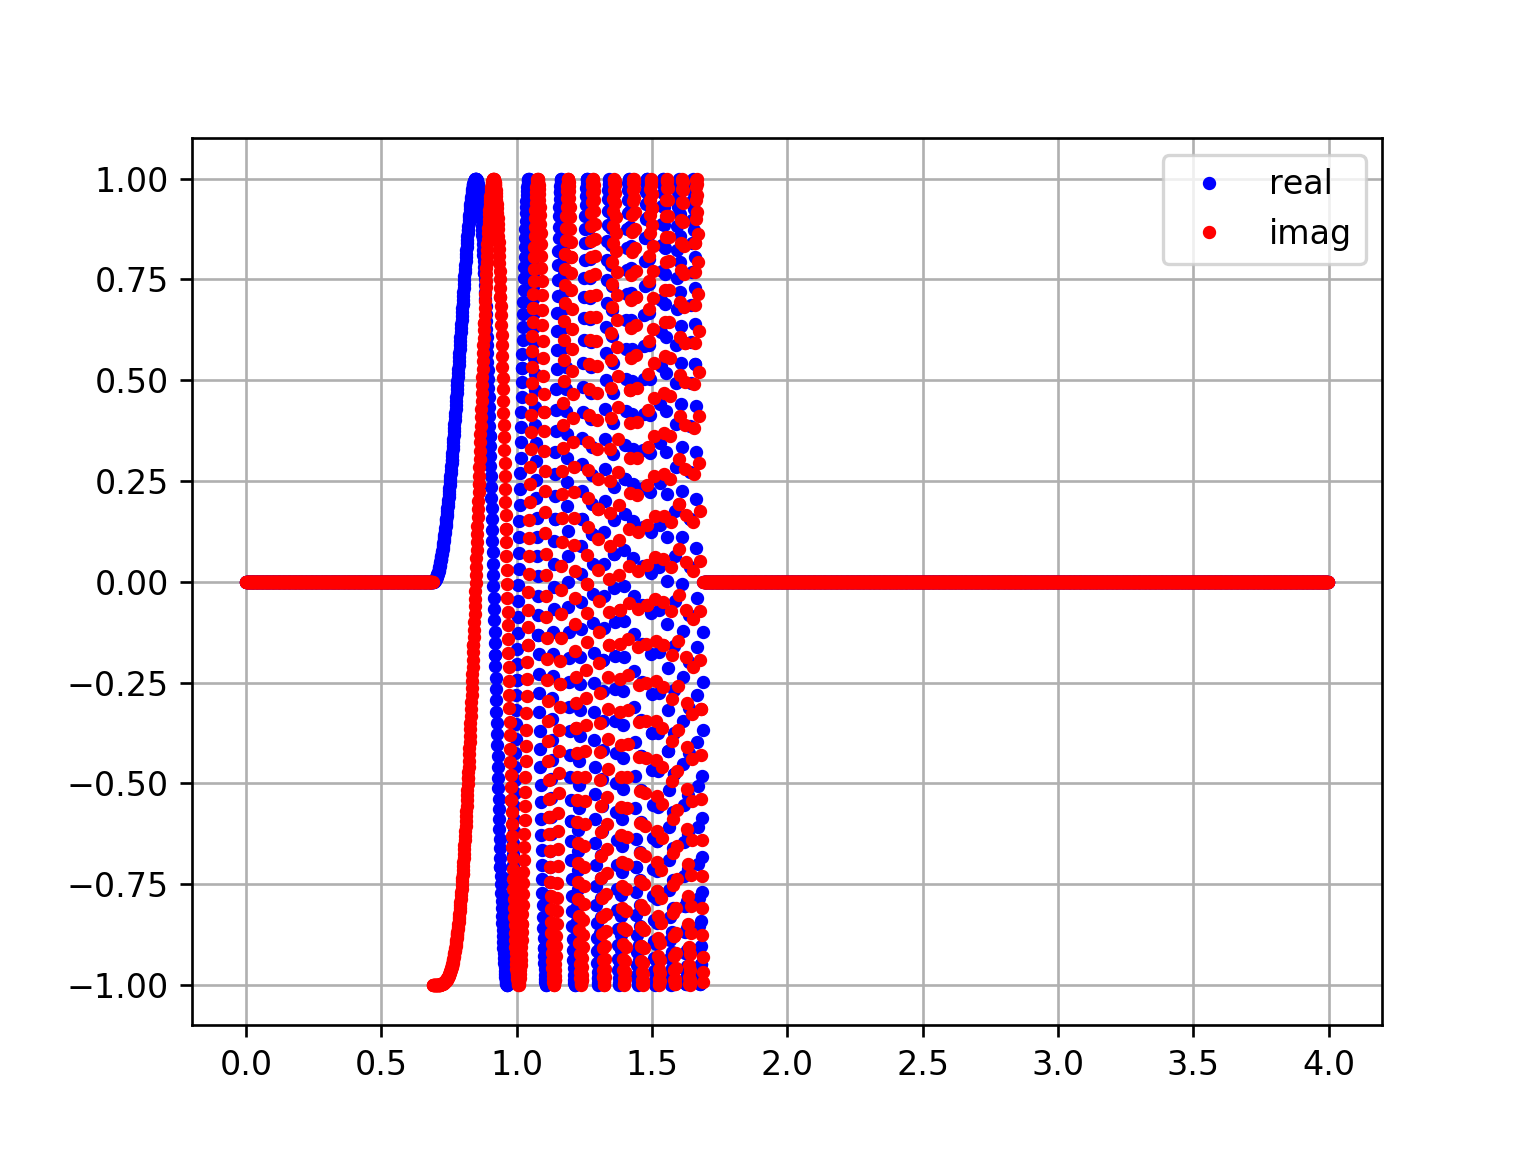

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

def timesOffset(start, stop, step, offset=0.0, returnStart=False):
    # create a series of times from start+offset to stop+offet (not included) at the specified step size
    # this is useful to quickly generate a time series with a sampling offset and different sampling rate
    
    if returnStart:
        return np.arange(start+offset, stop+offset, step), start+offset
    else:
        return np.arange(start+offset, stop+offset, step)

def chirpPhi(t, cw, t0=0.0, phi0=0.0, w0=0.0):
    # cw is chirp rate = dw/dt = 2*pi*df/dt
    dt = t - t0
    dt2 = np.multiply(t + t0, dt)
    phi = phi0 + (cw/2)*dt2 + (w0 - cw*t0)*dt
    return phi

def bw2slope(bw, tChirp):
    return 2*np.pi*bw/tChirp

def chirpAligned(start, stop, step, bw, cw,
                 t0=0.0, phi0=0.0, w0=0.0, offset=0.0):
    # create a single chirp of bandwidth bw (Hz), with a chirp slope of cw (dw/dt)
    # returns signal and corresponding sampling time
    
    t = timesOffset(start, stop, step, offset)
    tChirp = 2*np.pi*bw/np.abs(cw)  # time length of chirp
    nChirp = int(np.floor(tChirp/step)) # max number of samples taken up by chirp
    n0 = int(np.ceil((t0 - start)/step))  # first sample where chirp shows up
    nEnd = n0 + nChirp  # last sample where chirp shows up
    phi = chirpPhi(t[n0:nEnd], cw, t0=t0, phi0=phi0, w0=w0)    
    x = np.zeros(t.shape)
    x[n0:nEnd] = np.cos(phi)
    
    return t, x

def chirpQuadratureAligned(start, stop, step, bw, cw,
                 t0=0.0, phi0=0.0, w0=0.0, offset=0.0):
    # create a single chirp of bandwidth bw (Hz), with a chirp slope of cw (dw/dt)
    # returns signal and corresponding sampling time
    
    t = timesOffset(start, stop, step, offset)
    tChirp = 2*np.pi*bw/np.abs(cw)  # time length of chirp
    nChirp = int(np.floor(tChirp/step)) # max number of samples taken up by chirp
    n0 = int(np.ceil((t0 - start)/step))  # first sample where chirp shows up
    nEnd = n0 + nChirp  # last sample where chirp shows up
    phi = chirpPhi(t[n0:nEnd], cw, t0=t0, phi0=phi0, w0=w0)    
    x = np.zeros(t.shape, dtype=complex)
    x[n0:nEnd] = np.cos(phi) + 1j*np.sin(phi)
    
    return t, x


# chirp parameters
bw = 20  # bandwidth spanned by the chirp (Hz)
tChirp = 1.0  # time that chirp lasts
tsRef = 0.001  # sampling time of reference
chirpOffset = 0.69
phi0 = -np.pi/2
# phi0 = 0

# create signal
cw = bw2slope(bw, tChirp)  # slope of frequency variation
cwDown = -cw  # slope of corresponding downchirp
# real signal only
t, x = chirpAligned(0, 4.0, tsRef, bw, cw, t0=chirpOffset, phi0=phi0)
# quadrature signal
tq, xq = chirpQuadratureAligned(0, 4.0, tsRef, bw, cw, t0=chirpOffset, phi0=phi0)

tsSamp = 0.02  # just enough sampling rate
tSamp, xSamp = chirpAligned(0, 4.0, tsSamp, bw, cw, t0=chirpOffset, phi0=phi0)
tQSamp, xQSamp = chirpQuadratureAligned(0, 4.0, tsSamp, bw, cw, t0=chirpOffset, phi0=phi0)

# plot real signal
plt.figure()
plt.plot(t, x, 'b-')
plt.plot(tSamp, xSamp, 'r.')
plt.title("delayed signal")
plt.grid()

# plot quadrature signal
plt.figure()
plt.plot(tq, xq.real, 'b.', label="real")
plt.plot(tQSamp, xQSamp.real, 'b.')
plt.plot(tq, xq.imag, 'r.', label="imag")
plt.plot(tQSamp, xQSamp.imag, 'r.')
plt.grid()
plt.legend()

plt.show()

## Match Filtering

<IPython.core.display.Javascript object>


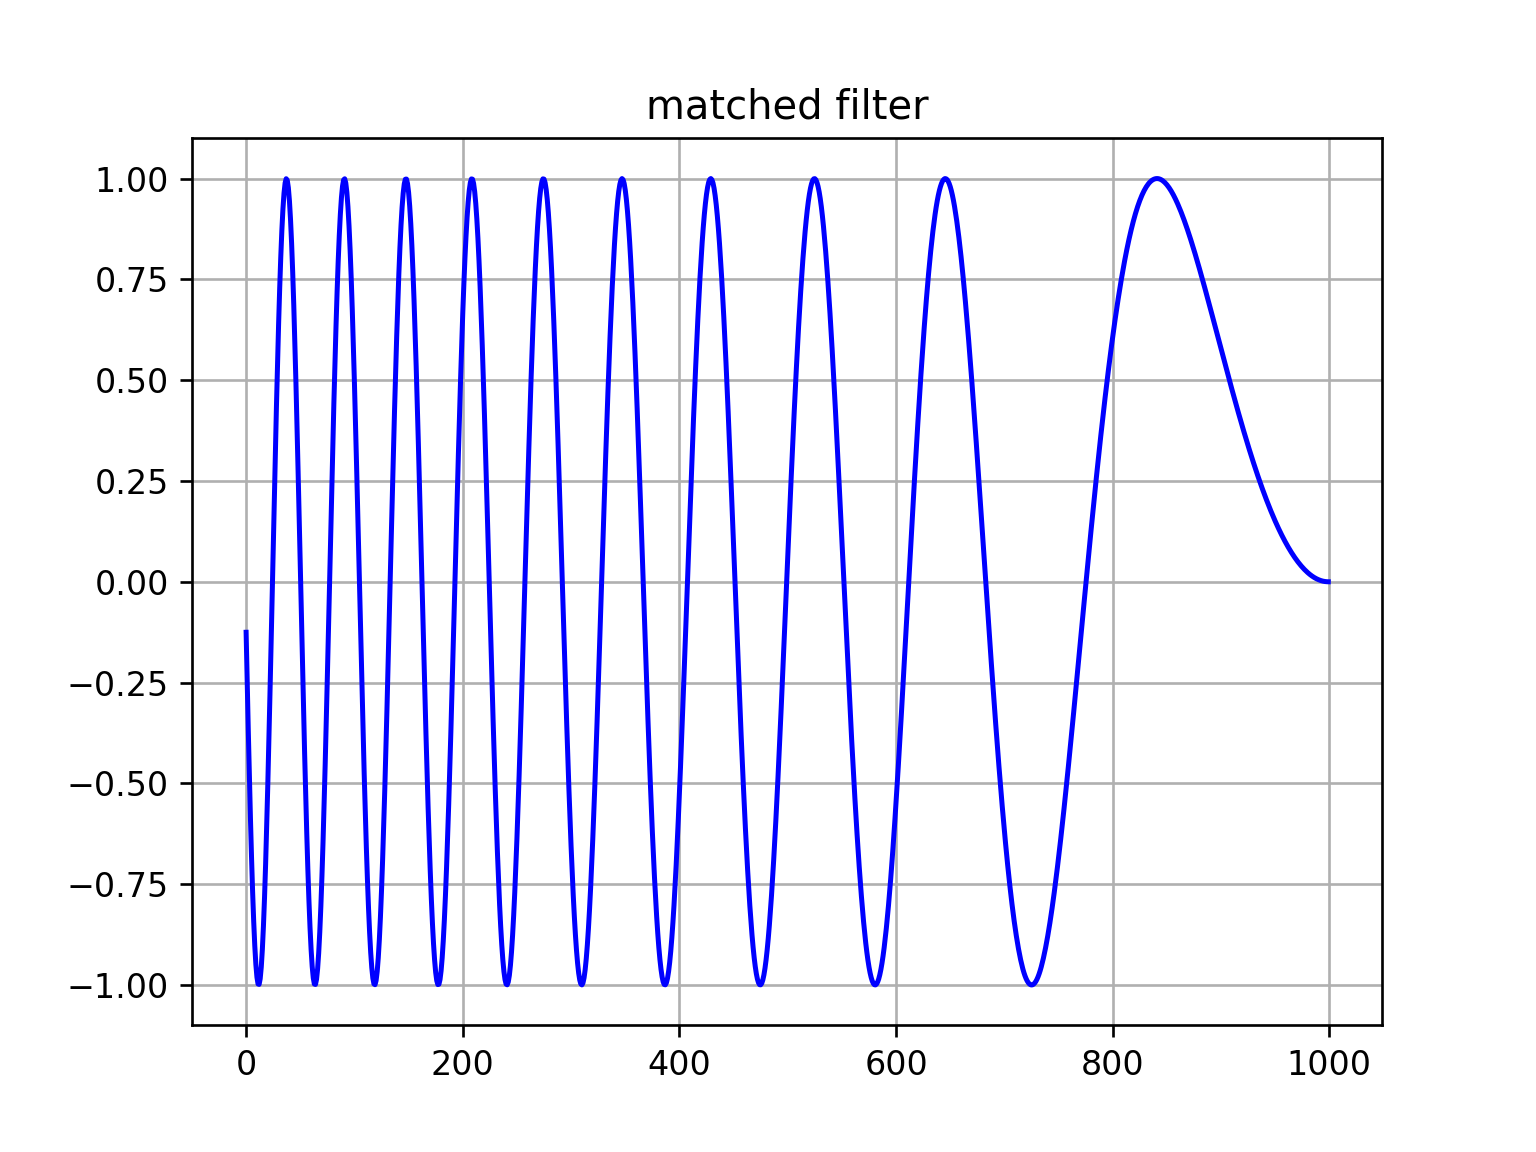

<IPython.core.display.Javascript object>


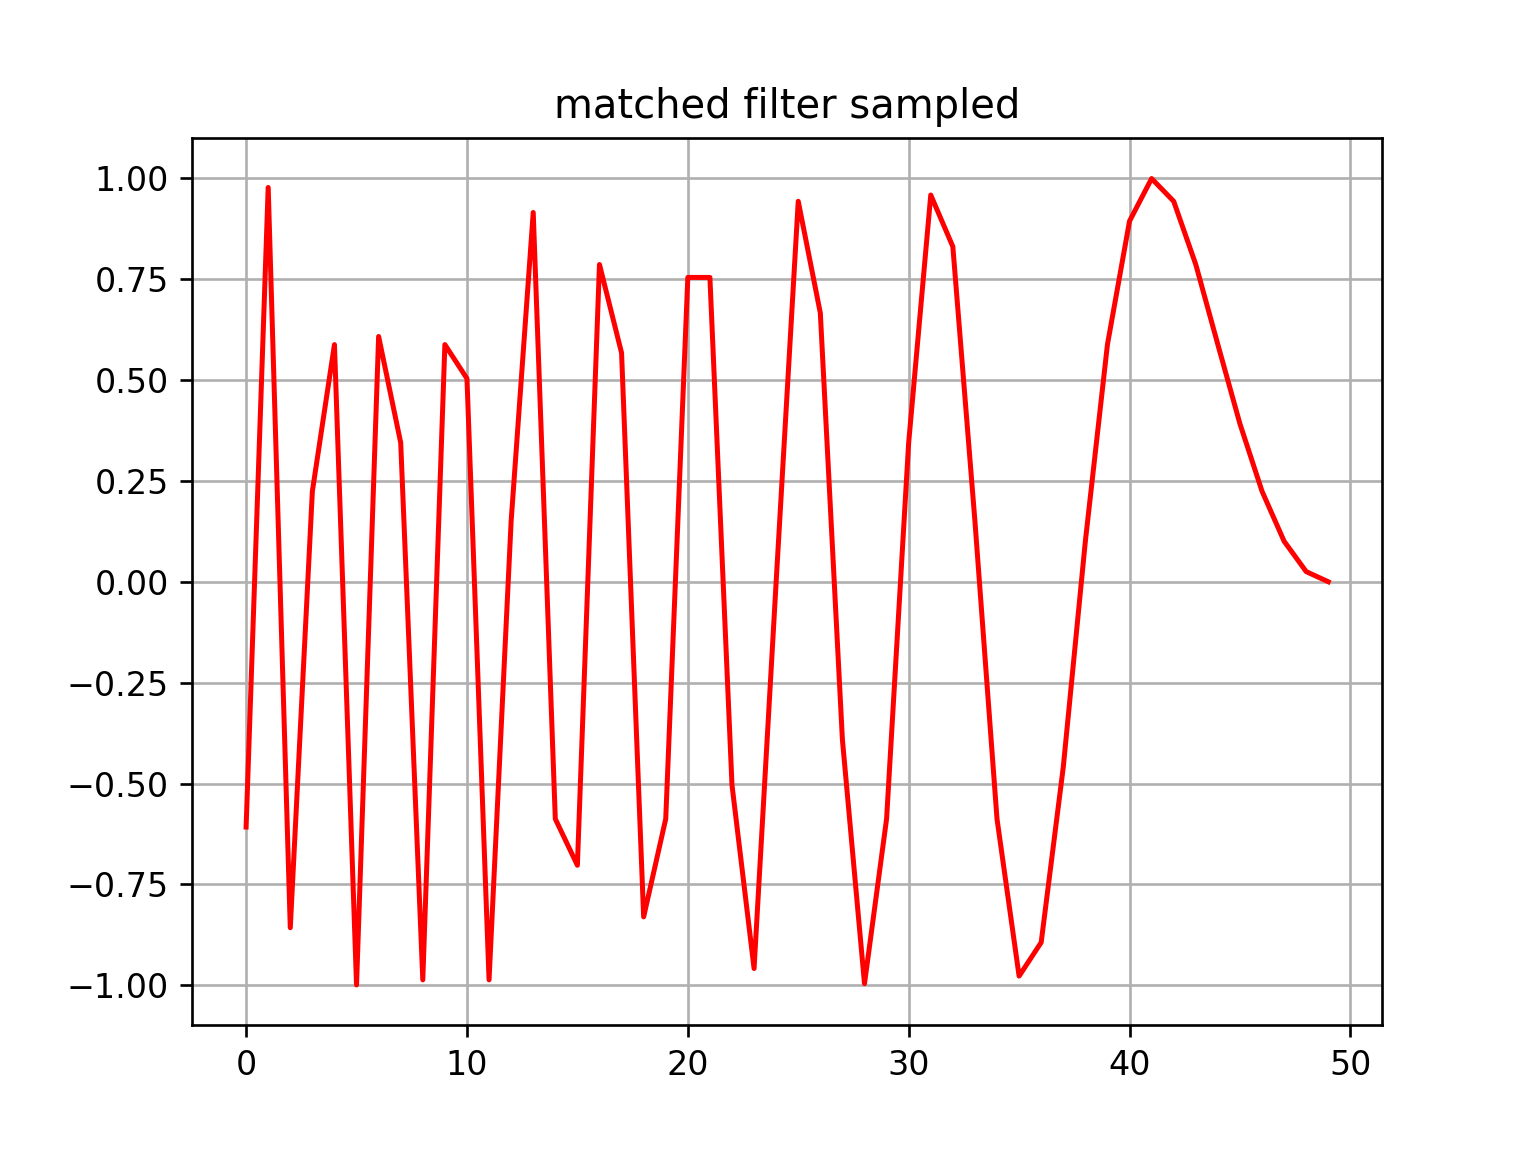

<IPython.core.display.Javascript object>


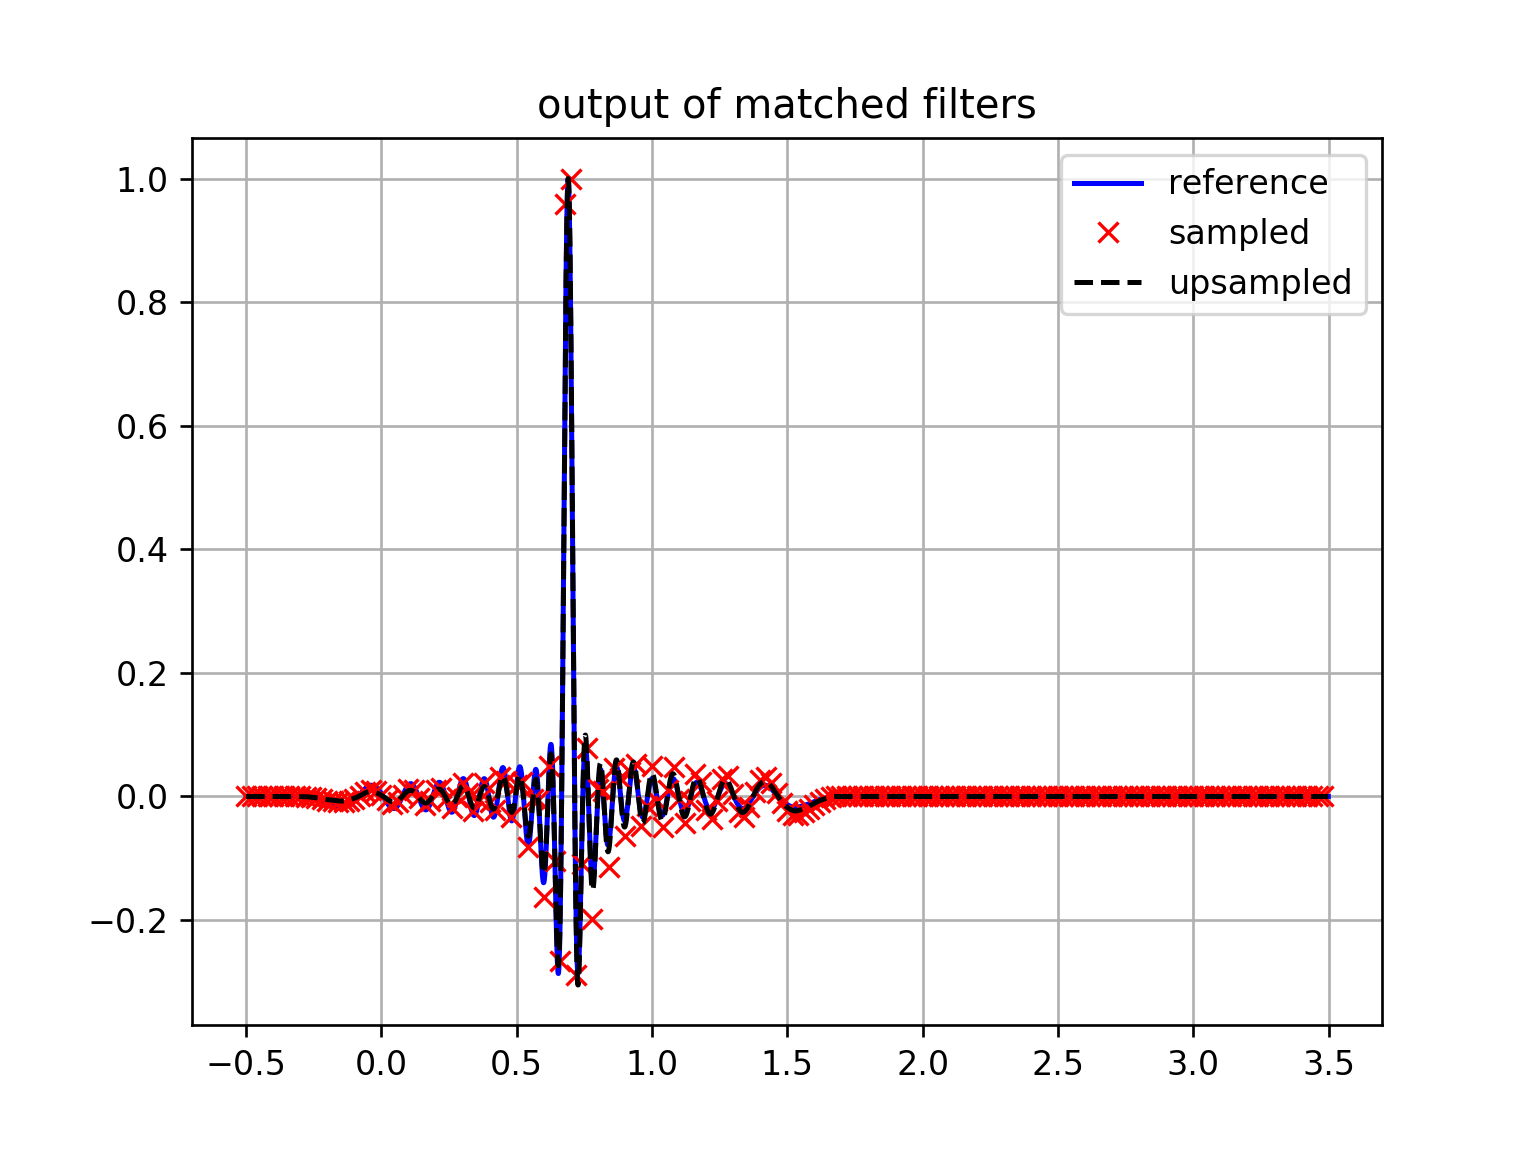

In [10]:
# create matched filter
TFilt = 1.0
tFilt, xFilt = chirpAligned(0.0, TFilt, tsRef, bw, cw, t0=0.0, phi0=phi0)
xFilt = np.flipud(xFilt)

tSFilt, xSFilt = chirpAligned(0.0, TFilt, tsSamp, bw, cw, t0=0.0, phi0=phi0)
xSFilt = np.flipud(xSFilt)

plt.figure()
plt.title("matched filter")
plt.plot(xFilt, 'b-')
plt.grid()

plt.figure()
plt.title("matched filter sampled")
plt.plot(xSFilt, 'r-')
plt.grid()

def normalize(signal):
    maxVal = np.max(np.abs(signal))
    return np.divide(signal, maxVal)

# convolve signal with matched filter

mfOut = np.convolve(x, xFilt, mode='same')
mfOutSamp = np.convolve(xSamp, xSFilt, mode='same')
mfOutResampled = sig.resample(mfOutSamp, mfOut.shape[0])

plt.figure()
plt.title("output of matched filters")
plt.plot(t - TFilt/2, normalize(mfOut), 'b-', label="reference")
plt.plot(tSamp - TFilt/2, normalize(mfOutSamp), 'rx', label="sampled")
plt.plot(t - TFilt/2, normalize(mfOutResampled), 'k--', label="upsampled")
plt.grid()
plt.legend()

plt.show()

## Stretch processing

<IPython.core.display.Javascript object>


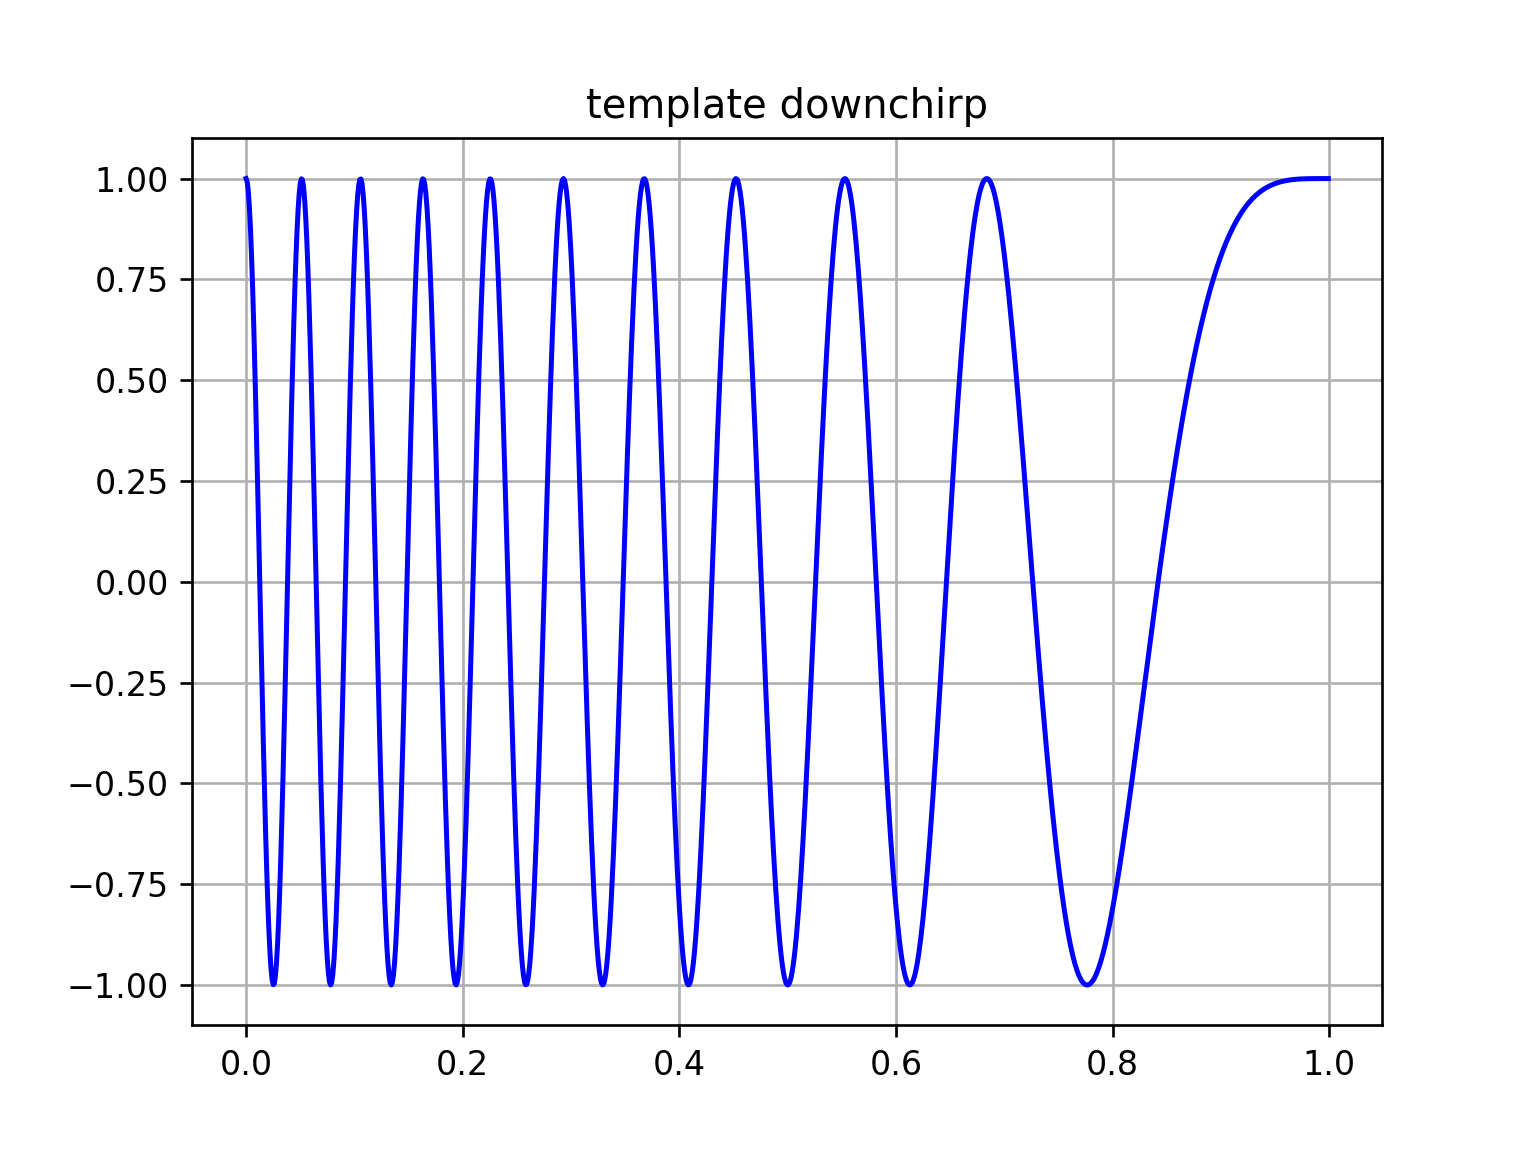

<IPython.core.display.Javascript object>


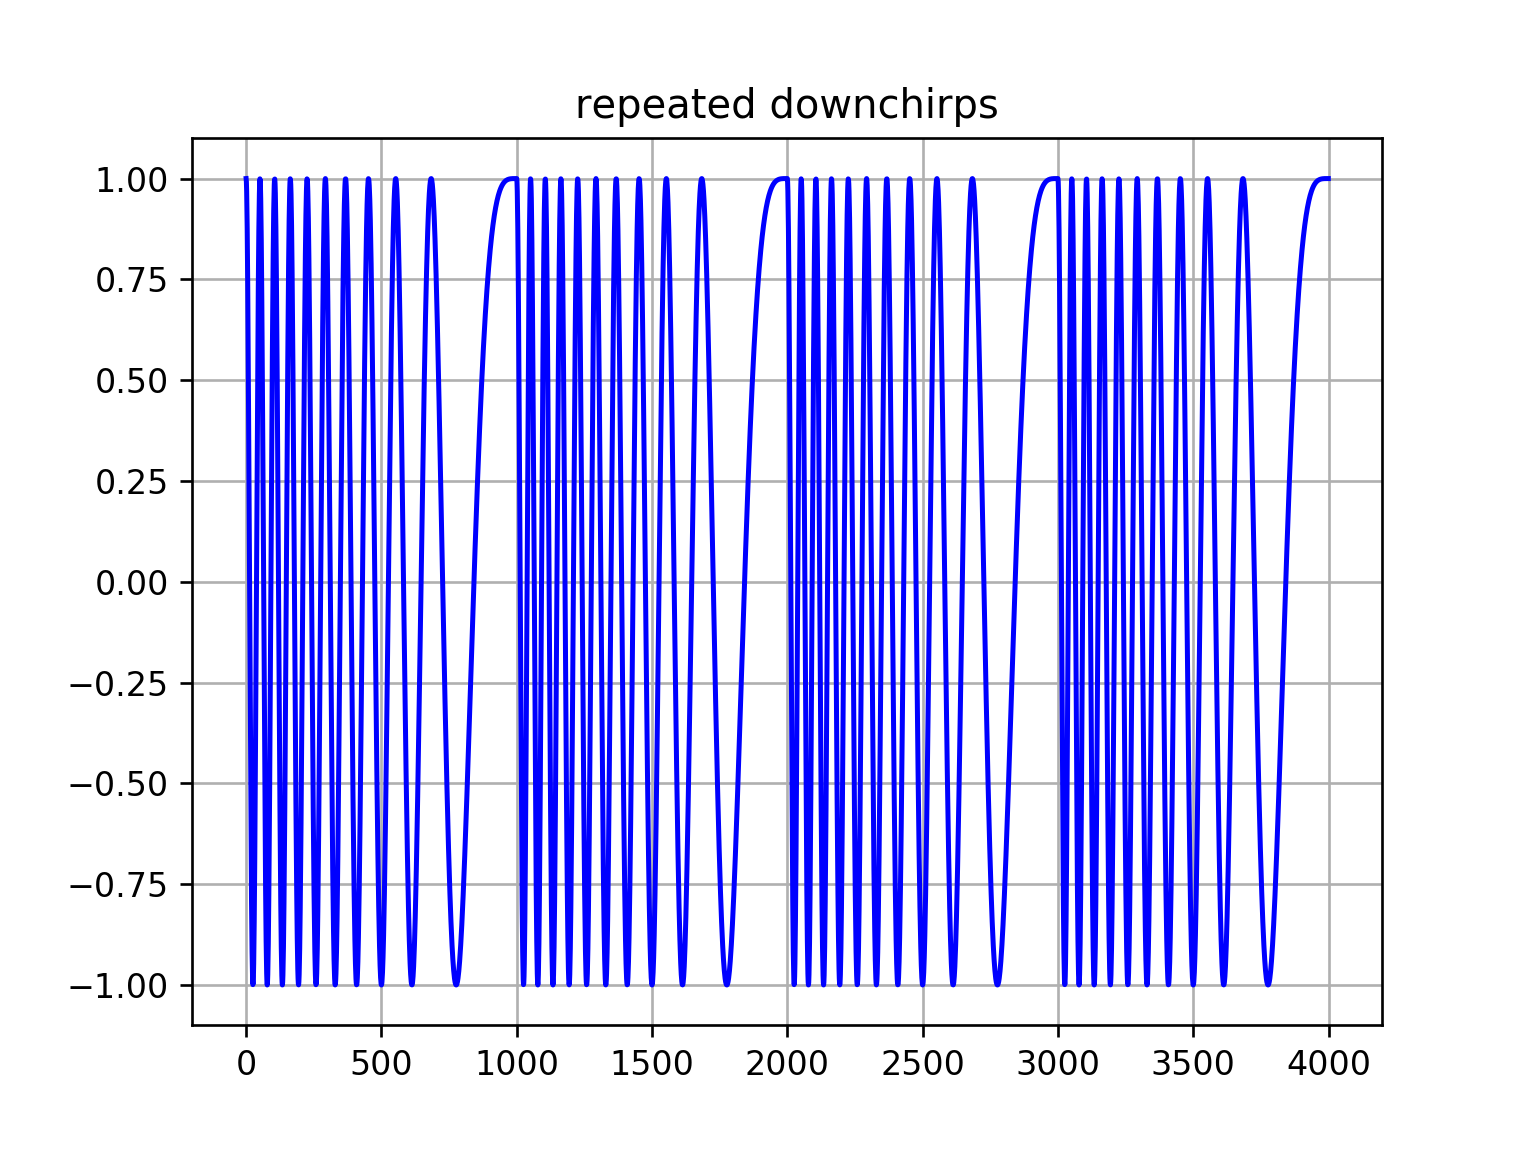

<IPython.core.display.Javascript object>


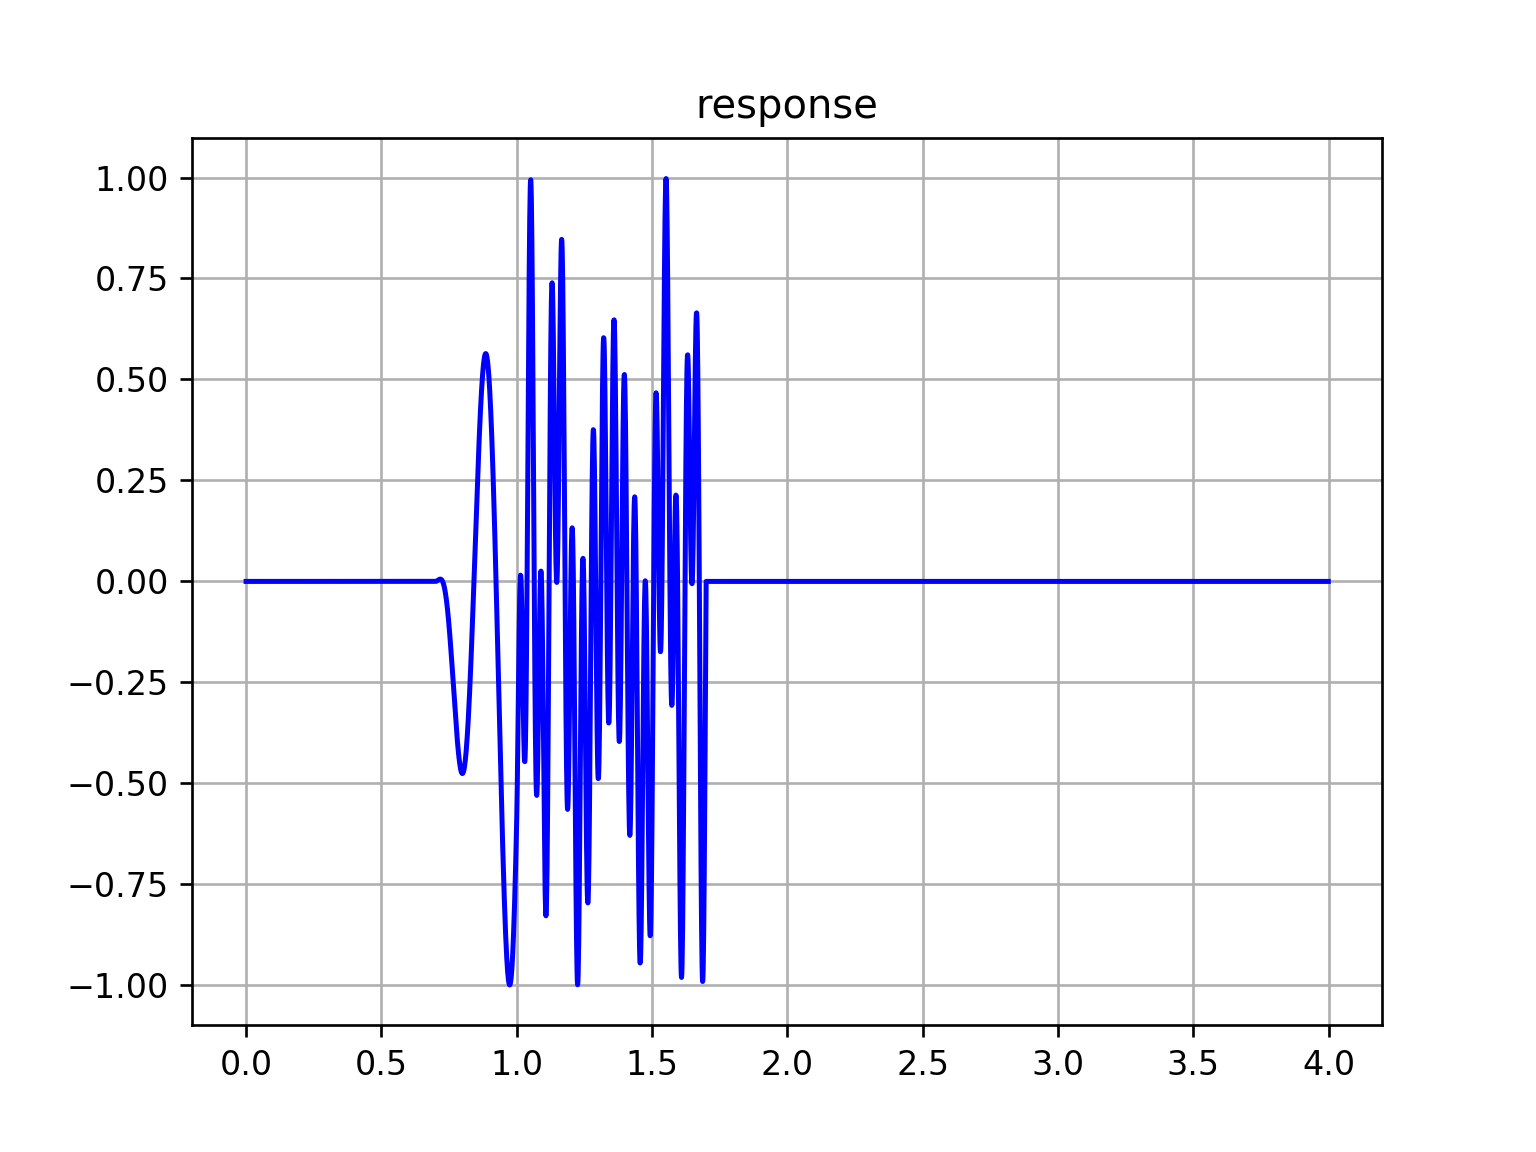

<IPython.core.display.Javascript object>


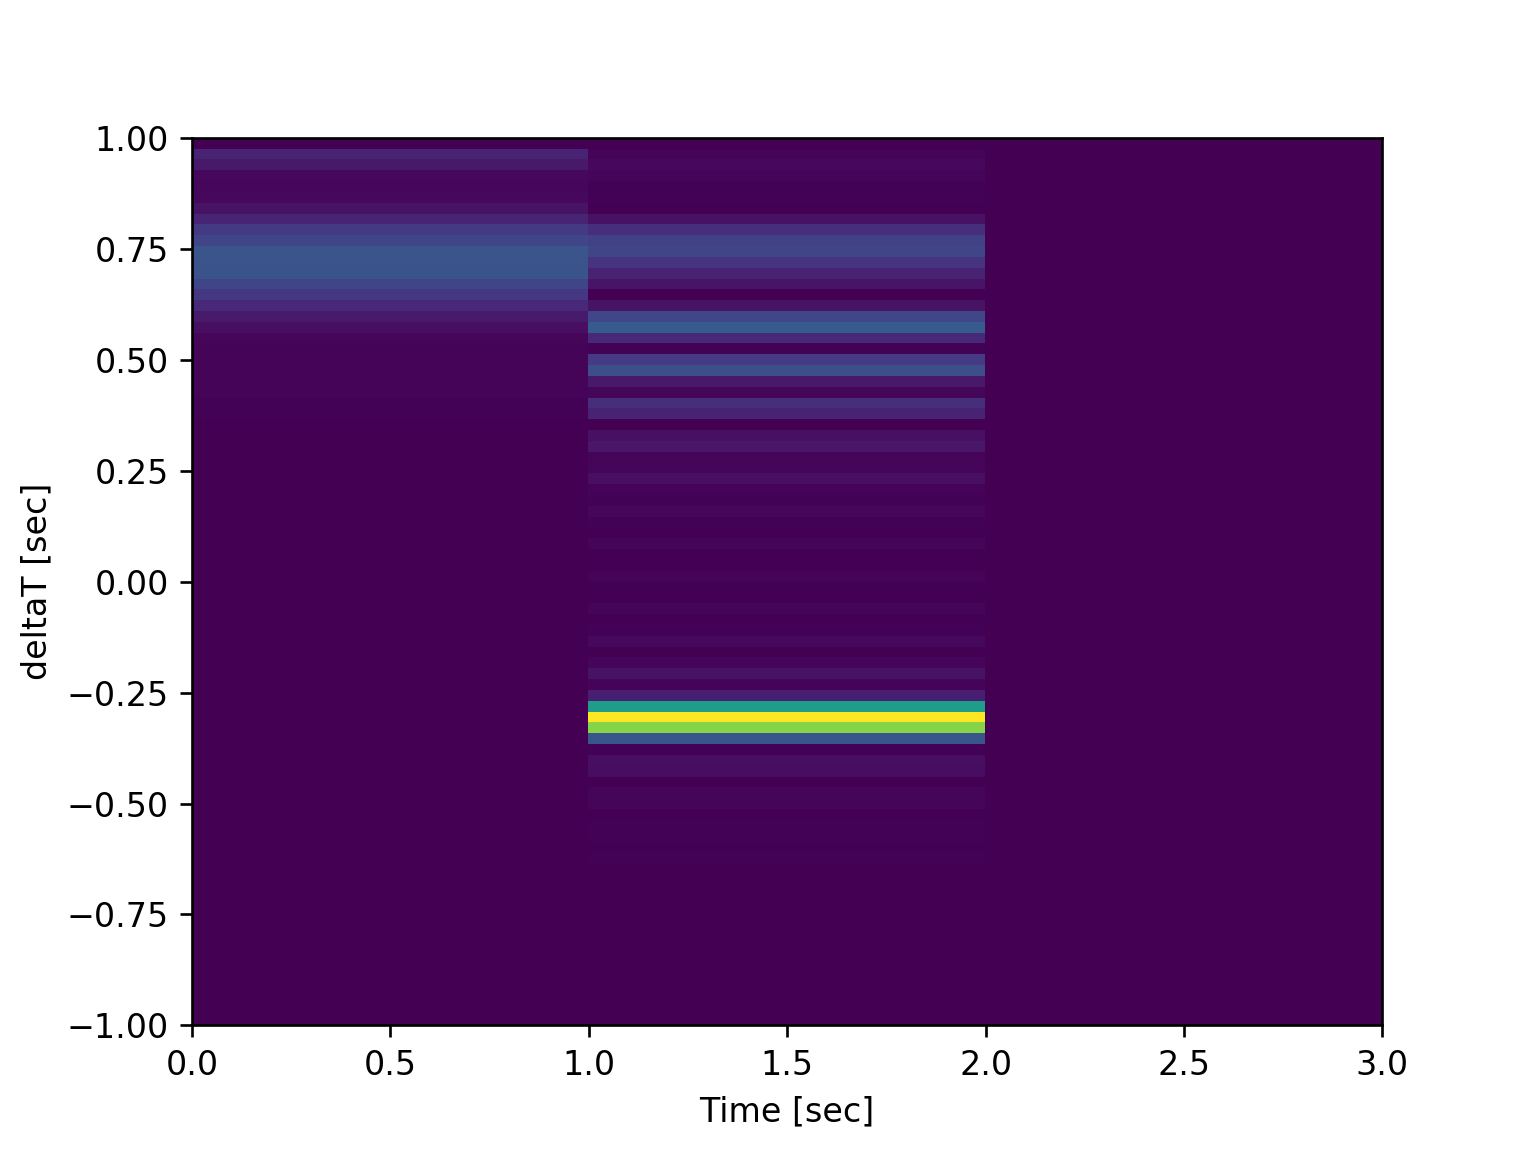

In [66]:
# create template downchirp
# tTemp, xTemp = chirpAligned(0.0, tChirp, tsRef, bw, cwDown, phi0=+np.pi/2, w0=2*np.pi*bw)
tTemp, xTemp = chirpAligned(0.0, tChirp, tsRef, bw, cwDown, phi0=0.0, w0=2*np.pi*bw)

plt.figure()
plt.plot(tTemp, xTemp, 'b-')
plt.title("template downchirp")
plt.grid()


xTempRepeat = np.resize(xTemp, x.shape)

plt.figure()
plt.plot(xTempRepeat, 'b-')
plt.title("repeated downchirps")
plt.grid()

# generate stretch processing result
resp = np.multiply(x, xTempRepeat)
plt.figure()
plt.plot(t, resp, 'b-')
plt.title("response")
plt.grid()

# show spectrogram of stretch processor
templateOffset = 0.5*tChirp

fSpec, tSpec, Sxx = sig.spectrogram(resp, 1/tsRef,
                                    nperseg=1000, noverlap=0, nfft=2048,
                                    mode='psd', window='boxcar')
deltaT = tChirp - fSpec*tChirp/(bw)
plt.figure()
# plt.pcolormesh(tSpec, fSpec, Sxx)
# plt.ylabel('Frequency [Hz]')
plt.pcolormesh(tSpec - templateOffset, deltaT, Sxx)
plt.ylabel('deltaT [sec]')
plt.xlabel('Time [sec]')
plt.ylim(-1.0, 1.0)

# print("fSpec.shape:", fSpec.shape)
# print("tSpec.shape:", tSpec.shape)
# print("Sxx.shape:", Sxx.shape)
# print("tSpec:", tSpec)

plt.show()

In [ ]:
# recreate the effects on a sampled version of the signal

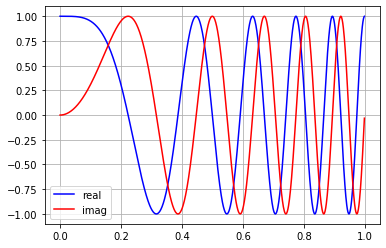

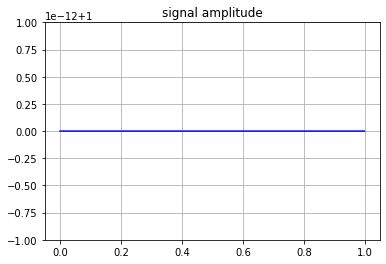

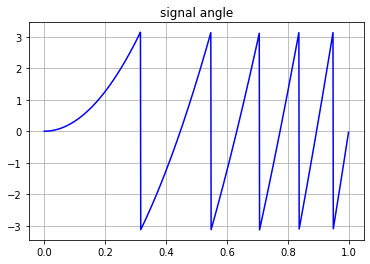

In [3]:
# check if scipy.signal.chirp performs the required function

import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

ts = 0.001
t = np.arange(0.0, 1.0, ts)
f1 = 0.0
f2 = 10.0

# Note: sin(x) = cos(x-pi/2)
xreal = sig.chirp(t, f1, t[-1], f2, method='linear', phi=0.0)
ximag = sig.chirp(t, f1, t[-1], f2, method='linear', phi=-90.0)
x = xreal + 1j*ximag

plt.figure()
plt.plot(t, xreal, 'b-', label='real')
plt.plot(t, ximag, 'r-', label='imag')
plt.legend()
plt.grid()

plt.figure()
plt.title("signal amplitude")
plt.plot(t, np.abs(x), 'b-')
plt.grid()

plt.figure()
plt.title("signal angle")
plt.plot(t, np.angle(x), 'b-')
plt.grid()

plt.show()